## Read the training data and import library

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('data/train.csv', encoding='Big5')
data = data.replace('NR', '0')
data = np.array(data)

## Feature variable 

In [ ]:
hour = 9
feature_num = 18
day_per_month = 20
per_month_row = feature_num * day_per_month
total_month = int(len(data)/per_month_row) 

## Process the data 9 hours

In [ ]:
month_data = []
for i in range(total_month):
    l = data[i * per_month_row: i * per_month_row  + per_month_row]
    month_data.append(l)  

hour_data = []
for i in range(len(month_data)):
    tmp = []
    for j in range(len(month_data[i])):
        tmp.append(month_data[i][j])
    hour_data.append(tmp)
    
total = []
for i in range(len(hour_data)):
    df = pd.DataFrame(hour_data[i])
    row, col = df.shape
    tmp = None
    for j in range(day_per_month):
        per_day = df.iloc[j*feature_num:j*feature_num+feature_num,:]
        per_day = per_day.iloc[:,3:]
        
        if tmp is not None:
            tmp = pd.concat([tmp.reset_index(drop=True), per_day.reset_index(drop=True)], axis=1, ignore_index=True)
        else:
            tmp = pd.DataFrame(per_day)   
     
    total.append(tmp)

In [ ]:
xss = []
yss = []
for i in range(len(total)):
    df = total[i]
    row, col = df.shape
    for j in range(col-hour-1):
        xs = df.iloc[:,j:j+hour]
        xs = xs.values.ravel()
        ys = float(df.iloc[9,j+hour])
        xss.append(xs)
        if(ys < 0):
            yss.append(0)
            continue         
        yss.append(float(ys))
        
xss = pd.DataFrame(xss).values.astype(np.float)
#np.column_stack(([1] * len(xss) ,xss)) ## if ho feature scaling
yss = np.array(yss)
ori_xss = xss
ori_yss = yss

In [ ]:
q75, q25 = np.percentile(yss, [75 ,25])
iqr = q75 - q25
lb = q25 - 1.5 * iqr
ub = q75 + 2 * iqr
model = list(zip(xss,yss))
model = [y for y in model if y[1] <= ub and y[1] >= lb]
xss = [y[0] for y in model]
yss = [y[1] for y in model]
print(len(ori_yss)-len(yss))

## Feature Selection

In [ ]:
import seaborn as sns
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

## Feature scaling

In [98]:
class standardScaler():
    def fit(self, xss):
        self.mean = np.mean(xss, axis=0)
        self.sd = np.std(xss, axis=0)

    def transform(self, xss):
        xss = (xss-self.mean)/(self.sd)
        return(xss)

In [99]:
scaler = standardScaler()
scaler.fit(xss)
xss = scaler.transform(xss)
row, col = xss.shape

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def calculate_vif_(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return (X.columns[variables], X[cols[variables]])

X_train = pd.DataFrame(xss)
res = calculate_vif_(X_train)
selected_var , xss = res[0], res[1].values

## Select only past pm2.5 as factor

In [70]:
selected_var = np.array([(i)*feature_num +9 for i in range(9)])
X_train = pd.DataFrame(xss)
X_train = X_train[selected_var]
xss = X_train.values
print(selected_var)

[  9  27  45  63  81  99 117 135 153]


## Train the model. Don't forget to remove the clear_output

In [65]:
from IPython.display import clear_output
max_iter = 10 ** 5
epochs = 10
lr = 1

xss = np.column_stack(([1] * len(xss) ,xss))
num = xss.shape[1]
w = np.zeros(num)
w_lr = np.zeros(num)

for t in range(epochs):
    w_grad = None
    for m in range(max_iter):
        predict = np.dot(xss,w)
        w_grad = -(2 * np.dot(xss.T,(yss - predict)))
        w_lr = w_lr + w_grad ** 2
        w = w - lr/np.sqrt(w_lr) * w_grad
        
    clear_output()
    print(t)
    print(np.sqrt(np.mean([ x*x for x in (yss-predict)])))

9
14.644156104537407


In [ ]:
ori_xss = scaler.transform(ori_xss)
ori_xss = np.column_stack(([1] * len(ori_xss) ,ori_xss))
predict = np.dot(ori_xss,w)
print(np.sqrt(np.mean([ x*x for x in (ori_yss-predict)])))

In [66]:
test = pd.read_csv('data/test.csv', encoding='Big5', header=None)
test = test.replace('NR', '0')
file = 'pm2.5only'

In [67]:
import pickle
dic = {'w': w, 'scaler': scaler, 'selected_var' : selected_var}
with open('model/'+file+'.pkl', 'wb') as f:
    pickle.dump(dic, f)

In [68]:
ans = pd.read_csv('data/sampleSubmission.csv', encoding='Big5')
test_feature = 18
total_test = []
row, col = test.shape
test_number = int(row/test_feature)
print(test_number)
for i in range(test_number):
    df = test.iloc[i*test_feature:(i+1)*test_feature, 2:]
    xs = df.values.ravel().astype(np.float)
    xs = (scaler.transform([xs])[0])
    xs = [xs[i] for i in range(len(xs)) if i in selected_var]
    xs = np.concatenate(([1], xs))
    val = np.dot(xs,w)
    val = max(val,0)
    ans.iloc[i,1] = val
ans.to_csv('data/'+file+'.csv',index=False)

240


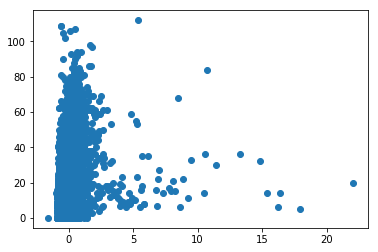

In [104]:
import matplotlib.pyplot as plt
plt.scatter(X_train.iloc[:,19], yss)

In [105]:
import glmnet_python
from glmnet import glmnet
from glmnetPlot import glmnetPlot
df1 = pd.read_csv('Advertising.csv')
allfeatures = ['TV', 'Newspaper', 'Radio']
fit = glmnet(xss,
y = yss,
alpha = 0, family = 'gaussian')
glmnetPlot(fit, xvar = 'lambda', label = True)

ModuleNotFoundError: No module named 'glmnet_python'